In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
from scipy import stats
from numpy import mean

In [3]:
import datetime as dt
#from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()

# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Using the inspector to print the column names within the 'measurement' & 'station' table 
#and its types to help in querying the db

inspector = inspect(engine)
inspector.get_table_names()
print("measurement")
print("--------------------------") 
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])
print("--------------------------") 
print("station")
print("--------------------------") 
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

measurement
--------------------------
id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT
--------------------------
station
--------------------------
id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [9]:
# Save references to each table
Measurement = Base.classes.measurement

Station = Base.classes.station

In [10]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

Max Measurement Date: 2017-08-23 00:00:00
Date a year ago:  2016-08-23


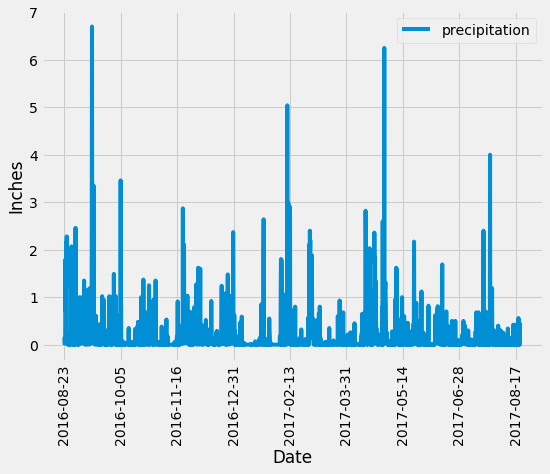

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database

#Calculate max date in Measurement
max_date = session.query(Measurement.date).order_by(Measurement.date.desc()).first()

#Convert tuple to string
max_date=''.join(max_date)

#Convert max_date String to Date datatype
convert_max_date=dt.datetime.strptime(max_date, "%Y-%m-%d")

print(f"Max Measurement Date: {convert_max_date}")

#Calculate the date 1 year ago from max_date

year_ago = dt.date(convert_max_date.year, convert_max_date.month ,convert_max_date.day) - dt.timedelta(days=365)

print("Date a year ago: ", year_ago)

# Perform a query to retrieve the data and precipitation scores
# Select only the `date` and `prcp` values.
sel = [Measurement.date,
       Measurement.prcp]

precipition_data = session.query(*sel).\
                   filter(Measurement.date >= year_ago).\
                   order_by(Measurement.date).all()

# Save the query results as a Pandas DataFrame and set the index to the date column

precipition_data_df = pd.DataFrame(precipition_data, columns=['date', 'precipitation'])

# set the index to the date column

precipition_data_df.set_index("date", inplace = True) 

# Sort the dataframe by date

precipition_data_df=precipition_data_df.sort_values('date',ascending=True)

#Clean dataframe by dropping null values

precipition_data_df=precipition_data_df.dropna()

# Use Pandas Plotting with Matplotlib to plot the data
# Plot the results using the DataFrame `plot` method.

precipition_data_df.plot(figsize=(8,6))

#Label axes
plt.xticks(rotation='vertical')
plt.xlabel("Date")
plt.ylabel("Inches")

#Saving graph to Images folder
plt.savefig("Images\Plot_Precipitation.png", bbox_inches = 'tight')

plt.show()

Inference from Graph:

a. Between 2016-08-23 and 2017-08-23, the months with highest rainfall are Sept 2016, Feb 2017, April 2017. However, we need to do more analysis to figure out which stations have the highest rainfall in these months.

In [12]:
# Use Pandas to print the summary statistics for the precipitation data.

Precipitation_Summary_df=precipition_data_df[["precipitation"]].describe().round(6)

Precipitation_Summary_df

,precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


In [13]:
# Design a query to show how many stations are available in this dataset?

station_count= session.query(Station).count()
print(f"Total number of stations: {station_count}")

Total number of stations: 9


In [14]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
sel_1 = [Measurement.station,
         func.count(Measurement.tobs)]
active_stations = session.query(*sel_1).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

print("Most active stations and the counts in descending order")
active_stations

Most active stations and the counts in descending order


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

#The first record from the previous query is most active station from the previous query
most_active_station=active_stations[0][0]

#Query lowest temperature recorded, highest temperature recorded, and average temperature of the most active station
sel_2 = [Measurement.station,
         func.min(Measurement.tobs),
         func.max(Measurement.tobs),
         func.avg(Measurement.tobs)]
active_station_temp = session.query(*sel_2).\
                      filter_by(station = most_active_station).\
                      group_by(Measurement.station).all()

print("Most active station with lowest temperature recorded, highest temperature recorded, and average temperature")
active_station_temp

Most active station with lowest temperature recorded, highest temperature recorded, and average temperature


[('USC00519281', 54.0, 85.0, 71.66378066378067)]

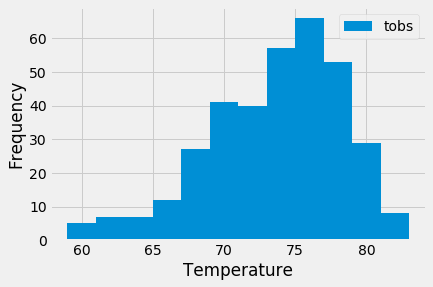

In [16]:
# Choose the station with the highest number of temperature observations.
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram

sel_3 = [Measurement.tobs]
highest_tobs = session.query(*sel_3).\
               filter(Measurement.station == most_active_station).\
               filter(Measurement.date >= year_ago).\
               order_by(Measurement.tobs.desc()).all()


#Plot histogram with bins = 12
highest_tobs_graph = list(np.ravel(highest_tobs))

plt.hist(highest_tobs_graph, bins = 12)

#Set labels
plt.xlabel("Temperature")
plt.ylabel("Frequency")

labels= ["tobs"]
plt.legend(labels)

#Saving graph to Images folder
plt.savefig("Images\Histogram_tobs.png", bbox_inches = 'tight')


plt.show()

Inference from the Graph:
    
    a. The most active station USC00519281 has a temperature variance of 54.0 - 85.0 F between 2016-08-23 and 2017-08-23.
    
    b. The highest frequency of temperature is around 75 F, thus making this place an ideal vacation spot.

## Bonus Challenge Assignment

### Temperature Analysis II

In [17]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [18]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.
start_date= '2016-07-01' 
end_date= '2017-07-01' 

temp_stats=calc_temps(start_date, end_date)

print(f"Minimum, average, and maximum temperatures for trip starting on {end_date} and previous year on {start_date}")
print(temp_stats)

Minimum, average, and maximum temperatures for trip starting on 2017-07-01 and previous year on 2016-07-01
[(58.0, 74.55179982440737, 87.0)]


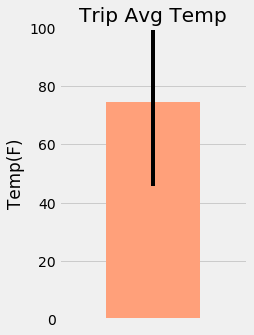

In [19]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr

#Create separate lists from the temp_stats tuple 
tmin_1, tavg_1,tmax_1 = zip(*temp_stats)

#Create dataframe
calc_temps_df = pd.DataFrame({
            'tmin':tmin_1,
            'tavg':tavg_1,
            'tmax':tmax_1})


# Plot the results from your previous query as a bar chart
calc_temps_df['tavg'].plot(kind='bar' ,yerr =calc_temps_df['tmax']-calc_temps_df['tmin']
                           , figsize = (3,5), color="#FFA07A");

#Set labels

plt.ylabel("Temp(F)")
plt.ylim(0,100)
plt.title("Trip Avg Temp")

#Hide x tick
plt.xticks(calc_temps_df['tavg'],"")

#Saving graph to Images folder
plt.savefig("Images\Bar_Avg-Temp.png", bbox_inches = 'tight')

plt.show()


Inference from Graph:

    a. The average temperature from 2016/07/01 to 2017/07/01 is 74.55 F for all stations.
    b. The margin of error is 29 F, which shows the variance of fluctuation in weather could be quite a bit.

In [20]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation

sel_4 = [Station.station,
         Station.name,
         func.sum(Measurement.prcp),
         Station.latitude,
         Station.longitude,
         Station.elevation]

total_rainfall = session.query(*sel_4).\
                      filter(Station.station==Measurement.station).\
                      filter(Measurement.date >= start_date).\
                      filter(Measurement.date <= end_date).\
                      group_by(Measurement.station,Station.name,Station.latitude,Station.longitude,Station.elevation).\
                      order_by(func.sum(Measurement.prcp).desc()).all()

#print total rainfall with station info
for station, name, rainfall, latitude, longitude,elevation  in total_rainfall:
    print("Station:",station, "| Name: ",name,"|Total Rainfall: ",rainfall," inches |lat: ",latitude,
          "|lng: ",longitude, "|elevation: ",elevation)

Station: USC00516128 | Name:  MANOA LYON ARBO 785.2, HI US |Total Rainfall:  165.9499999999999  inches |lat:  21.3331 |lng:  -157.8025 |elevation:  152.4
Station: USC00519281 | Name:  WAIHEE 837.5, HI US |Total Rainfall:  92.60000000000007  inches |lat:  21.45167 |lng:  -157.84888999999998 |elevation:  32.9
Station: USC00513117 | Name:  KANEOHE 838.1, HI US |Total Rainfall:  63.04000000000005  inches |lat:  21.4234 |lng:  -157.8015 |elevation:  14.6
Station: USC00519523 | Name:  WAIMANALO EXPERIMENTAL FARM, HI US |Total Rainfall:  45.43  inches |lat:  21.33556 |lng:  -157.71139 |elevation:  19.5
Station: USC00514830 | Name:  KUALOA RANCH HEADQUARTERS 886.9, HI US |Total Rainfall:  34.29  inches |lat:  21.5213 |lng:  -157.8374 |elevation:  7.0
Station: USC00519397 | Name:  WAIKIKI 717.2, HI US |Total Rainfall:  23.110000000000003  inches |lat:  21.2716 |lng:  -157.8168 |elevation:  3.0
Station: USC00517948 | Name:  PEARL CITY, HI US |Total Rainfall:  5.27  inches |lat:  21.3934 |lng:  -

In [21]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [22]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip
trip_start='2017-07-01'
trip_end='2017-07-07'

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(trip_start, trip_end).tolist()


# Stip off the year and save a list of %m-%d strings
month_day=[]
for x in trip_date_range:
    month_day.append(x.strftime("%m-%d"))

# Loop through the list of %m-%d strings and calculate the normals for each date
normals=[]
for x in month_day:
    normals=normals + daily_normals(x)

print(f"Daily normals for trip staring on {trip_start} and ending on {trip_end}")
normals

Daily normals for trip staring on 2017-07-01 and ending on 2017-07-07


[(67.0, 74.77777777777777, 81.0),
 (68.0, 75.40384615384616, 82.0),
 (68.0, 75.32075471698113, 87.0),
 (70.0, 76.57142857142857, 81.0),
 (66.0, 75.0, 81.0),
 (69.0, 75.0, 81.0),
 (69.0, 74.91071428571429, 82.0)]

In [23]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index

#create lists from tuples
tmin, tavg,tmax = zip(*normals)

# Create the dataframe
Trip_df = pd.DataFrame({
            'trip_dates':trip_date_range,
            'tmin':tmin,
            'tavg':tavg,
            'tmax':tmax})

#set date as index
Trip_df.set_index("trip_dates", inplace = True) 

Trip_df

,tmin,tavg,tmax
trip_dates,,,
2017-07-01,67.0,74.777778,81.0
2017-07-02,68.0,75.403846,82.0
2017-07-03,68.0,75.320755,87.0
2017-07-04,70.0,76.571429,81.0
2017-07-05,66.0,75.000000,81.0
2017-07-06,69.0,75.000000,81.0
2017-07-07,69.0,74.910714,82.0


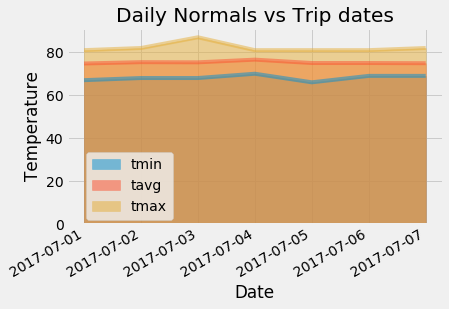

In [24]:
# Plot the daily normals as an area plot with `stacked=False`

Trip_df.plot(kind='area', stacked=False, title='Daily Normals vs Trip dates',x_compat=True).legend(bbox_to_anchor=(.3, .4))

#set labels
plt.xlabel('Date')
plt.ylabel('Temperature')

#Saving graph to Images folder
plt.savefig("Images\Area_Daily-Normals.png", bbox_inches = 'tight')

plt.show()

Inference from graph:

a. The average temparature in the area graph is pretty consistent (74 - 76.5 F) for the vacation duration which makes Hawaii a pretty ideal spot for vacation.

b. There is slight fluctuation in max temperature on 7/3/17 (87 F) and min temperature on 7/5/17 (66 F). However, the fluctuation aren't too high or low. But it would be interesting to analyze the data further to see what caused these fluctuations.

## Temperature Analysis I

* Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?
* You may either use SQLAlchemy or pandas's `read_csv()` to perform this portion.
* Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.
* Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [25]:
# Identify the average temperature in June at all stations across all available years in the dataset. 
# Do the same for December temperature.

# Get list of tobs for June and December
June_result = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '06').all()
Dec_result = session.query(Measurement.tobs).filter(func.strftime("%m", Measurement.date) == '12').all()

# Filter out null values from lists and append final result to new lists
June_result_list = []
for t in June_result:
    if type(t.tobs) == float:
        June_result_list.append(t.tobs)
        
Dec_result_list = []
for t in Dec_result:
    if type(t.tobs) == float:
        Dec_result_list.append(t.tobs)   
        


In [26]:
#Identify the average temperature in June and Dec at all stations across all available years in the dataset

# Average temperature for June
Jun_mean=mean(June_result_list)

# Average temperature for Dec
Dec_mean=mean(Dec_result_list)

print("Average Temp in June: "+str(Jun_mean))
print("Average Temp in December: "+str(Dec_mean))


Average Temp in June: 74.94411764705882
Average Temp in December: 71.04152933421226


In [27]:
# Unpaired (independent) t-test
stats.ttest_ind(June_result_list,Dec_result_list)

Ttest_indResult(statistic=31.60372399000329, pvalue=3.9025129038616655e-191)

a. An unpaired t-test is performed on the dataset since it compares the means of different groups.

b. The p value for mean temperatures for June and Decemeber is very very small (pvalue=3.9025129038616655e-191), thus indicating that the results are statistically significant.